# Distillation Conversation with Large Language Models
 
### Notebook details
 
This sample demonstrates how to train the selected student model using the teacher model, resulting in the creation of the distilled model.
 
We will use the Meta Llama 3.1 405B Instruct as the teacher model and the Meta Llama 3.1 8B Instruct as the student model.
 
**Note :**
 
- Distillation should only be used for single turn chat completion format.
- The Meta Llama 3.1 405B Instruct model can only be used as a teacher model.
- Distillation of a Meta Llama 3.1 8B Instruct student (target) model is only available in **West US 3** regions.
- Distillation of Phi3 or Phi3.5 student (target) models is only available in **East US 2** regions.

**Prerequisites :**
- Subscribe to the Meta Llama 3.1 405B Instruct and Meta Llama 3.1 8B Instruct, see [how to subscribe your project to the model offering in MS Learn](https://learn.microsoft.com/en-us/azure/ai-studio/how-to/deploy-models-serverless?tabs=azure-ai-studio#subscribe-your-project-to-the-model-offering)

# 1. Connect to Azure Machine Learning Workspace

The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. In this section we will connect to the workspace in which the job will be run.

## 1.1. Install the SDK v2

In [ ]:
%pip install azure-ai-ml
%pip install azure-identity
%pip install azure-core
%pip install azure-ai-inference

%pip install mlflow
%pip install azureml-mlflow
%pip install datasets

## 1.2. Import the required libraries

In [ ]:
# # import required libraries

import json
import uuid

from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential

from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.ai.ml import MLClient, Input, Output
from azure.ai.ml.constants import AssetTypes, DataGenerationTaskType, DataGenerationType
from azure.ai.ml.model_customization import (
    distillation,
    EndpointRequestSettings,
    PromptSettings,
)
from azure.ai.ml.entities import Data, ServerlessConnection, ServerlessEndpoint
from azure.core.credentials import AzureKeyCredential

## 1.3. Configure workspace details and get a handle to the workspace

To connect to a workspace, we need identifier parameters - a subscription, resource group and workspace name. We will use these details in the `MLClient` from `azure.ai.ml` to get a handle to the required workspace. We use the [default azure authentication](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity.defaultazurecredential?view=azure-python) for this tutorial. Check the [configuration notebook](../../configuration.ipynb) for more details on how to configure credentials and connect to a workspace.


### 1.3.1 Prerequisites

For distillation of a Meta Llama 3.1 8B student model, an Azure AI Foundry project in **West US 3** is required. Please follow [this](https://learn.microsoft.com/azure/ai-studio/how-to/fine-tune-model-llama?tabs=llama-two%2Cchatcompletion#prerequisites) document to setup your Azure AI Foundry project

If you are using a Phi 3 or Phi 3.5 student model, an Azure AI Foundry project in **East US 2** is required. Follow [this](https://learn.microsoft.com/en-us/azure/ai-studio/how-to/fine-tune-phi-3?tabs=phi-3-mini#prerequisites) document to setup your Azure AI Foundry project

### 1.3.2 Azure AI Foundry project settings

Update following cell with the information of the Azure AI Foundry project just created.

In [ ]:
SUBSCRIPTION_ID = "<SUBSCRIPTION>"
RESOURCE_GROUP = "<RESOURCE_GROUP>"
AI_PROJECT_NAME = "<AI_PROJECT_NAME>"

In [ ]:
try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

### 1.3.3 Get handle to Azure AI Foundry project

In [ ]:
ml_client = MLClient(credential, SUBSCRIPTION_ID, RESOURCE_GROUP, AI_PROJECT_NAME)

ai_project = ml_client._workspaces.get(ml_client.workspace_name)
ai_project._workspace_id

## 2. Data

### 2.1 Download the dataset from HuggingFace repo
- For our example, we download and use the Quora dataset: https://huggingface.co/datasets/twodgirl/baize-quora
- The dataset from hugging face is in the below format
    
    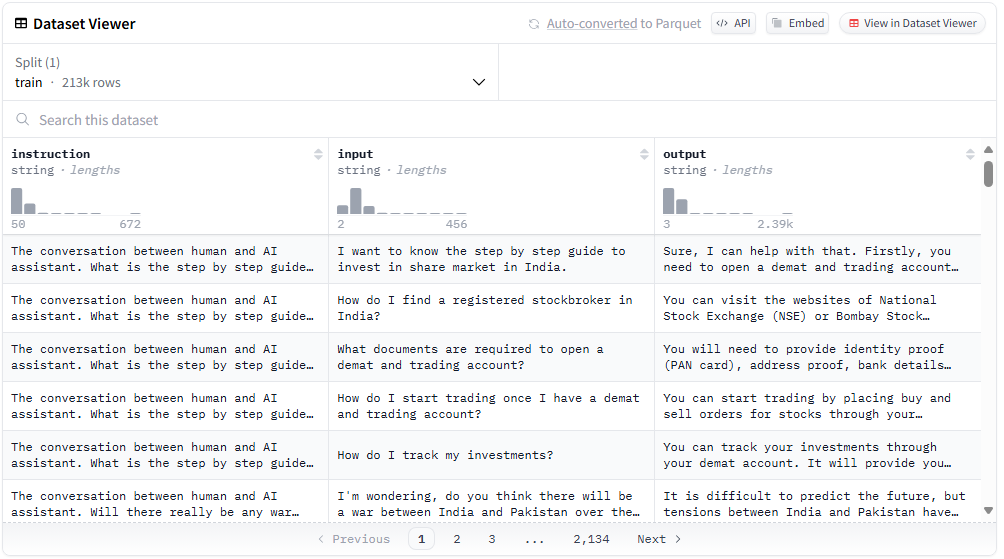
    
- For this example the data will be transformed into chat completion format and the system prompt is overriden with the one given below
    
    **SystemPrompt**
    ```text
    The following is a conversation between a human and an AI assistant. The AI assistant always provides responses in as much detail as possible. The AI assistant will never ask personal information. The AI assistant always declines to engage with topics, questions and instructions related to unethical, controversial, or sensitive issues. Complete the conversation transcript.
    ```
    
    ---

    **Transformed Data**

    ```JSON
    {
    "messages": [
        {
            "role": "system",
            "content": "The following is a conversation between a human and an AI assistant. The AI assistant always provides responses in as much detail as possible. The AI assistant will never ask personal information. The AI assistant always declines to engage with topics, questions and instructions related to unethical, controversial, or sensitive issues. Complete the conversation transcript."
        },
        {
            "role": "user",
            "content": "I want to know the step by step guide to invest in share market in India."
        },
        {
            "role": "assistant",
            "content": "Sure, I can help with that. Firstly, you need to open a demat and trading account with a registered stockbroker."
        },
        {
            "role": "user",
            "content": "How do I find a registered stockbroker in India?"
        },
        {
            "role": "assistant",
            "content": "You can visit the websites of National Stock Exchange (NSE) or Bombay Stock Exchange (BSE) to get a list of registered stockbrokers in India."
        }...
    ]
    }
    ```

In [ ]:
from datasets import load_dataset
from pathlib import Path


def load_hf_dataset(
    dataset_name,
    system_prompt,
    train_sample_size=100,
    val_sample_size=100,
    test_sample_size=100,
    train_split_name="train",
):

    full_dataset = load_dataset(dataset_name)
    train_data = full_dataset[train_split_name]
    full_df = train_data.to_pandas()
    conversations = list(full_df.groupby("instruction", sort=False))
    conversations = conversations[
        : train_sample_size + val_sample_size + test_sample_size
    ]
    all_conversations_chat_format = []
    for instruction, conversation_df in conversations:
        conversation = {"messages": []}
        conversation_df.reset_index(drop=True, inplace=True)
        for i, row in conversation_df.iterrows():
            if i == 0:
                conversation["messages"].append(
                    {"role": "system", "content": system_prompt}
                )
            conversation["messages"].append({"role": "user", "content": row["input"]})
            conversation["messages"].append(
                {"role": "assistant", "content": row["output"]}
            )
        all_conversations_chat_format.append(conversation)
    train_data = all_conversations_chat_format[:train_sample_size]
    val_data = all_conversations_chat_format[
        train_sample_size : train_sample_size + val_sample_size
    ]
    test_data = all_conversations_chat_format[
        train_sample_size
        + val_sample_size : train_sample_size
        + val_sample_size
        + test_sample_size
    ]

    return train_data, val_data, test_data

In [ ]:
# We can define train and test sample sizes here.
train_sample_size = 100
val_sample_size = 100
system_prompt = "The following is a conversation between a human and an AI assistant. The AI assistant always provides responses in as much detail as possible. The AI assistant will never ask personal information. The AI assistant always declines to engage with topics, questions and instructions related to unethical, controversial, or sensitive issues. Complete the conversation transcript."
# Sample notebook using the dataset: https://huggingface.co/datasets/twodgirl/baize-quora
dataset_name = "twodgirl/baize-quora"


# Note: train_split_name and test_split_name can vary by dataset. They are passed as arguments in load_hf_dataset.
# If val_split_name is None, the below function will split the train set to create the specified sized validation set.
train, val, _ = load_hf_dataset(
    dataset_name=dataset_name,
    system_prompt=system_prompt,
    train_sample_size=train_sample_size,
    val_sample_size=val_sample_size,
)

print("Len of train data sample is " + str(len(train)))
print("Len of validation data sample is " + str(len(val)))

In [ ]:
! mkdir -p data

In [ ]:
train_data_path = Path(f"data/train_quora_{train_sample_size}.jsonl")
valid_data_path = Path(f"data/valid_quora_{val_sample_size}.jsonl")

In [ ]:
with open(train_data_path, "w") as f:
    for row in train:
        f.write(json.dumps(row) + "\n")

with open(valid_data_path, "w") as f:
    for row in val:
        f.write(json.dumps(row) + "\n")

### 2.4 Create Data Input

In [ ]:
# Training data defined locally, with local data to be uploaded
train_data = Input(type=AssetTypes.URI_FILE, path=train_data_path)

# If training data was registered to workspace already, navigate to the Data tab, select the data to use and use the 'Named asset URI'.
# Example of the format is seen below
# train_data = "azureml:train_conversation_quora:1"

In [ ]:
# Validation data defined locally, with local data to be uploaded
valid_data = Input(type=AssetTypes.URI_FILE, path=valid_data_path)

# If validation data was registered to workspace already, navigate to the Data tab, select the data to use and use the 'Named asset URI'.
# Example of the format is seen below
# valid_data = "azureml:validation_conversation_quora:1"

## 3. Configure and Run the Distillation Job
In this section we will configure and run a Distillation job.

### 3.1 Configure the job through the distillation() factory function

#### distillation() parameters:

The `distillation()` factory function allows user to configure Distillation for the label generation task for the most common scenarios with the following properties.

- `experiment_name` - The name of the Experiment. An Experiment is like a folder with multiple runs in Azure ML Workspace that should be related to the same logical machine learning experiment.
- `data_generation_type` - The type of data generation to perform. Valid options are 'label_generation'.
- `data_generation_task_type` - The kind of data to generation. Valid options include 'NLI', 'NLI_QA', 'CONVERSATION', 'MATH', and 'SUMMARIZATION'.
- `teacher_model_endpoint_connection` - A ServerlessConnection geared towards a MaaS endpoint. Requires the name of the endpoint, the endopoint url, and the api key for the endpoint.
- `student_model` - The student model to train with the synthetic data generated from the teacher model.
- `training_data` - The data to be used for training.
- `validation_data` - The data to be used for validation.
- `name` - The name of the Job/Run. This is an optional property. If not specified, a random name will be generated.

**Note:** 
- For each turn in the conversation data, the assistant's response is generated by the teacher model, utilizing the user prompt and the preceding chat history. This synthetic response then replaces the original assistant response in the dataset.
- The distillation process will proceed using the conversation data generated in this manner.


##### Teacher Model Connection
Select the teacher model to use. This requires a serverless (MaaS) endpoint. Supported teacher models:
1. Meta-Llama-3.1-405B-Instruct

Replace the following strings with your own serverless endpoint information



In [ ]:
teacher_model_endpoint_name = "Meta-Llama-3-1-405B-Instruct-vkn"
teacher_model_endpoint_url = "https://Meta-Llama-3-1-405B-Instruct-vkn.westus3.models.ai.azure.com/chat/completions"
teacher_model_api_key = "EXAMPLE_API_KEY"

#### Student Model
Select the student model to use. Supported student models:
1. Meta-Llama-3.1-8B-Instruct
2. Phi-3-Mini-4k-Instruct
3. Phi-3-Mini-128k-Instruct
4. Phi-3.5-Mini-Instruct
5. Phi-3.5-MoE-Instruct
6. Phi-3-Medium-4k-Instruct
7. Phi-3-Medium-128k-Instruct

In [ ]:
# The model id
student_model = (
    "azureml://registries/azureml-meta/models/Meta-Llama-3.1-8B-Instruct/versions/3"
)

In [ ]:
distillation_job = distillation(
    experiment_name="llama-conversation-distillation",
    data_generation_type=DataGenerationType.LABEL_GENERATION,
    data_generation_task_type=DataGenerationTaskType.CONVERSATION,
    teacher_model_endpoint_connection=ServerlessConnection(
        name=teacher_model_endpoint_name,
        endpoint=teacher_model_endpoint_url,
        api_key=teacher_model_api_key,
    ),
    student_model=student_model,
    training_data=train_data,
    validation_data=valid_data,
    outputs={
        "registered_model": Output(
            type="mlflow_model", name="llama-conversation-distilled"
        )
    },
)

### 3.2 Configure the distillation settings

#### set_teacher_model_settings() function parameters:
This is an optional configuration method to configure the settings inference requests will have when submitted to the teacher model endpoint.     
    
- `inference_parameters` - Inference parameters that are applied to inferencing requests. These inference parameters are aligned with parameters allowed by vllm. Currently, the inference parameters that are used by distillation are 'max_tokens', 'temperature', 'top_p', 'frequency_penalty', 'presence_penalty', and 'stop'.

- `endpoint_request_settings` - An EndpointRequestSettings object that adds settings for the inferencing requests sent to the endpoint. Valid endpoint settings include 'min_endpoint_success_ratio' and 'request_batch_size'.
    - `min_endpoint_success_ratio` - The minimum ratio of successful/total inferencing request needed for data generation to be considered successful. Will not proceed if the number of successful/total inferencing requests is below the ratio. Should be between 0 and 1, inclusive. Defaults to 0.7.
    - `request_batch_size` - The number of inferencing requests to send at once to the teacher model endpoint. Defaults to 10.

#### set_finetuning_settings() function parameters:
This is an optional configuration method to configure the settings for finetuning the student model.

- `hyperparameters` - The hyperparameters to use for finetuning.

In [ ]:
# Optional settings to use for inferencing requests
distillation_job.set_teacher_model_settings(
    inference_parameters={"max_tokens": 200, "temperature": 0.8},
    endpoint_request_settings=EndpointRequestSettings(
        min_endpoint_success_ratio=0.7, request_batch_size=10
    ),
)

# Optional settings to use for finetuning the student model
distillation_job.set_finetuning_settings(
    hyperparameters={
        "learning_rate": "0.00002",
        "per_device_train_batch_size": "1",
        "num_train_epochs": "3",
    }
)

### 3.2 Submit the Job
Using the `MLClient` created earlier, we will now run this Command in the workspace.

In [ ]:
created_job = ml_client.jobs.create_or_update(distillation_job)

#### Wait Until the Distillation Job Finishes

In [ ]:
print(created_job.name)
ml_client.jobs.stream(created_job.name)

## 4. Distilled Model Consumption
With the model distilled, we can now consume the model by creating an endpoint and sending inference requests.

### 4.1 Create a Serverless Endpoint
We first deploy the endpoint as a serverless endpoint (MaaS endpoint)

In [ ]:
# Wait for the job to complete
registered_model_name = ml_client.jobs.get(created_job.name).properties[
    "registered_ft_model_name"
]

In [ ]:
# Create the model url for registered endpoint
rg_model_vs = ml_client.models.get(registered_model_name, label="latest")._version

rg_model_asset_id = (
    "azureml://locations/"
    f"{ai_project.location}"
    "/workspaces/"
    f"{ai_project._workspace_id}"
    "/models/"
    f"{registered_model_name}"
    "/versions/"
    f"{rg_model_vs}"
)

In [ ]:
# Create serverless endpoint - names must be unique
guid = uuid.uuid4()
short_guid = str(guid)[:8]
serverless_endpoint_name = "my-endpoint-" + short_guid

serverless_endpoint = ServerlessEndpoint(
    name=serverless_endpoint_name,
    model_id=rg_model_asset_id,
)

created_endpoint = ml_client.serverless_endpoints.begin_create_or_update(
    serverless_endpoint
).result()

### 4.2. Endpoint Inferencing
With the serverless endpoint running, we now can send inference requests to the endpoint

**Note:** If the student model selected was Phi-3-medium-4k-instruct or Phi-3-medium-128k-instruct, the following section will not work as Phi-3-medium models do not accept system prompts. Instead skip to section 4.2.1

In [ ]:
url = created_endpoint.scoring_uri
key = ml_client.serverless_endpoints.get_keys(created_endpoint.name).primary_key
model = ChatCompletionsClient(
    endpoint=url,
    credential=AzureKeyCredential(key),
)

response = model.complete(
    messages=[
        SystemMessage(content=system_prompt),
        UserMessage(content="I wanted to ask if backward time travel is possible."),
    ],
)

print(response.choices[0].message.content)

### 4.2.1 Endpoint Inferencing (Phi-3-medium models)
With the serverless endpoint running, we now can send inference requests to the endpoint

**Note:** Skip this section if the student model was **NOT** a Phi-3-medium model

In [ ]:
url = created_endpoint.scoring_uri
key = ml_client.serverless_endpoints.get_keys(created_endpoint.name).primary_key
model = ChatCompletionsClient(
    endpoint=url,
    credential=AzureKeyCredential(key),
)

response = model.complete(
    messages=[
        UserMessage(
            content=system_prompt
            + " I wanted to ask if backward time travel is possible."
        ),
    ],
)

print(response.choices[0].message.content)

## 5. (Optional) Distilled Model Benchmarking

### 5.1 Create connection to submit benchmarking job

In [ ]:
from azure.ai.ml.entities import (
    WorkspaceConnection,
    ApiKeyConfiguration,
)


connection_name = "my-connection" + short_guid
api_key = key

ws_connection = WorkspaceConnection(
    name=connection_name,
    type="azure_sql_db",
    target=url,
    credentials=ApiKeyConfiguration(key=api_key),
)

ml_client.connections.create_or_update(workspace_connection=ws_connection)

### 5.2 The distilled model could be evaluated and benchmarked against hellaswag huggingface dataset with the same endpoint.

Below cell launches the evaluation pipeline job using [serverless compute](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-use-serverless-compute) by default. You can optionally [create your own compute cluster](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-attach-compute-cluster) and use it to execute the job.

**Note:** This section will not work if the student model was a Phi-3-medium model. Please skip to section 6

In [ ]:
from azure.ai.ml import load_job

# load the pipeline from the yaml def
pipeline_job = load_job(f"./pipelines/hellaswag.yaml")

# Sample ratio - what fraction of the dataset to run for the eval?
# **WARNING** be aware of endpoint costs!
sample_ratio = 0.01
experiment_name = "<Experiment name>"

# Set pipeline job inputs
pipeline_job.inputs.endpoint_url = url
pipeline_job.inputs.connection_name = connection_name
pipeline_job.inputs.sample_ratio = sample_ratio

# Optionally use your own compute cluster
# pipeline_job.settings.default_compute = "<Your compute cluster name>"

# Start the job in the Workspace
returned_job = ml_client.jobs.create_or_update(
    pipeline_job, experiment_name=experiment_name
)
returned_job

In [ ]:
# Wait until the job completes
ml_client.jobs.stream(returned_job.name)

### 5.3 Retrieve metrics from the run

When the pipeline finishes, you can retrieve evaluation metrics from the run via mlflow. The primary measure of accuracy for the evals is task dependant eg. `conversation` performance is usually measured in `mean_exact_match` scores

In [ ]:
import mlflow

accuracy_metric_name = "mean_exact_match"

mlflow_tracking_uri = ml_client.workspaces.get(
    ml_client.workspace_name
).mlflow_tracking_uri
mlflow.set_tracking_uri(mlflow_tracking_uri)

run = mlflow.get_run(run_id=returned_job.name)
metric_val = run.data.metrics[accuracy_metric_name]

if sample_ratio < 1.0:
    print(
        f"**Warning** sample_ratio is {sample_ratio}. Use sample_ratio=1.0 when comparing metrics between models."
    )

print(f"Eval: {experiment_name}")
print(f"Sample ratio: {sample_ratio}")
print(f"Accuracy metric name: {accuracy_metric_name}")
print(f"Accuracy metric value: {metric_val}")

## 6. Cleanup Endpoint

Endpoint deployments are chargeable and incurr costs on the subscription. Optionally clean up the endpoints after finishing experiments

In [ ]:
_ = ml_client.serverless_endpoints.begin_delete(teacher_model_endpoint_name)
_ = ml_client.serverless_endpoints.begin_delete(serverless_endpoint_name)